In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from split_data import split
import torch
import numpy as np
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from utils import *

plt.style.use('ggplot')

In [79]:
def preprocess1():
    
    transform = transforms.Compose([
                    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
                    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
                    ])
    return transform

In [80]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")


  
source_path = "../Combined_data"
training_path = "../Combined_train_test/train"
testing_path = "../Combined_train_test/test"
train_test_ratio = 0.7
# split(source_path, training_path, testing_path, train_test_ratio) 

# -------------[transform into suitable size for transfer learning]--------------------
transformation = preprocess1()

train_dataset = ImageFolder(training_path, transform = preprocess1())

test_dataset = ImageFolder(testing_path, transform = preprocess1())

classes = train_dataset.classes


batch_size = 32
learning_rate = 0.001
train_val_ratio = 0.8
num_epochs = 10
val_size = int(np.round(len(train_dataset) * (1-train_val_ratio)))
train_size = len(train_dataset) - val_size 

train_data, val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)

test_dl = DataLoader(test_dataset, batch_size, num_workers = 4, pin_memory = True)
num_classes = len(classes)


Using mps
Length of Train Data : 34430
Length of Validation Data : 8608


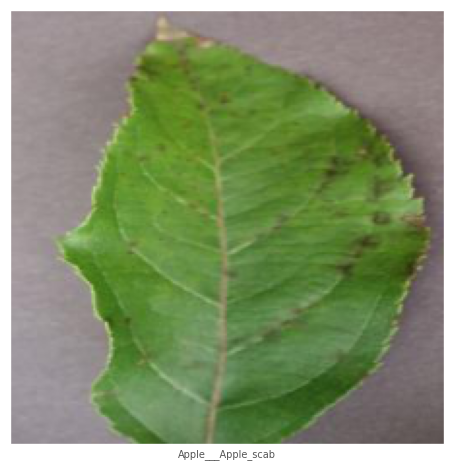

In [81]:
display_img(*train_dataset[0], classes)

In [82]:
efficient_model = load_efficient_net().to(device)
num_classes = len(classes)

efficient_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(efficient_model.parameters(), lr=learning_rate)
efficient_results = train(model=efficient_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=num_epochs,
                device=device)

torch.save(efficient_model, "../Models/no_preprocess_efficient_model.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2413 | train_acc: 0.9304 | train_f1: 0.9304 | val_loss: 0.0911 | val_acc: 0.9691 | val_f1: 0.9691 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 0.0870 | train_acc: 0.9724 | train_f1: 0.9724 | val_loss: 0.1486 | val_acc: 0.9626 | val_f1: 0.9626 | 
--------------------------------------------------------------


In [ ]:
efficient_report = test_run(efficient_model, test_dl, device, classes)
print(efficient_report)

In [7]:
hyperlist = ["(32, 0.01)", "(32, 0.001)", "(32, 0.05)", "(32, 0.005)", "(64, 0.01)", "(64, 0.001)", "(64, 0.05)", "(64, 0.005)", "(128, 0.01)", "(128, 0.001)", "(128, 0.05)", "(128, 0.005)"]
model_names = ["efficient_model", "mobile_model","resnet_model"]
report = {}

In [8]:
for model_name in model_names:
    for param in hyperlist:
        model_path = "../Models/compared_models/"+model_name+param+".pt"

        model = torch.load(model_path, map_location=torch.device('mps'))
        
        report[model_name+param] = test_run(model, test_dl, device, classes)


In [14]:
print(report["efficient_model(32, 0.01)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.84      0.98      0.91       300
                            Apple___Black_rot       0.91      0.99      0.95       300
                     Apple___Cedar_apple_rust       0.99      1.00      1.00       300
                              Apple___healthy       1.00      0.90      0.95       494
                    Background_without_leaves       0.99      0.96      0.97       343
                          Blueberry___healthy       0.98      0.99      0.99       451
                      Cherry___Powdery_mildew       0.98      0.97      0.97       316
                             Cherry___healthy       0.87      1.00      0.93       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.81      0.97      0.88       300
                           Corn___Common_rust       0.99      0.99      0.99       358
                  Corn___Northern_Leaf_Bli

In [15]:
print(report["efficient_model(32, 0.001)"])   #best efficient

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      1.00      1.00       300
                            Apple___Black_rot       1.00      1.00      1.00       300
                     Apple___Cedar_apple_rust       1.00      1.00      1.00       300
                              Apple___healthy       0.99      1.00      1.00       494
                    Background_without_leaves       1.00      0.99      1.00       343
                          Blueberry___healthy       1.00      1.00      1.00       451
                      Cherry___Powdery_mildew       1.00      1.00      1.00       316
                             Cherry___healthy       1.00      0.99      1.00       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.98      0.98       300
                           Corn___Common_rust       1.00      1.00      1.00       358
                  Corn___Northern_Leaf_Bli

In [16]:
print(report["efficient_model(32, 0.005)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.97      0.99      0.98       300
                            Apple___Black_rot       0.99      0.99      0.99       300
                     Apple___Cedar_apple_rust       1.00      1.00      1.00       300
                              Apple___healthy       0.98      0.99      0.98       494
                    Background_without_leaves       0.99      0.94      0.97       343
                          Blueberry___healthy       1.00      0.99      1.00       451
                      Cherry___Powdery_mildew       1.00      0.99      0.99       316
                             Cherry___healthy       0.98      1.00      0.99       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.89      0.94      0.91       300
                           Corn___Common_rust       1.00      0.99      1.00       358
                  Corn___Northern_Leaf_Bli

In [17]:
print(report["efficient_model(32, 0.05)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.80      0.80      0.80       300
                            Apple___Black_rot       0.97      0.88      0.92       300
                     Apple___Cedar_apple_rust       0.97      0.98      0.98       300
                              Apple___healthy       0.93      0.92      0.93       494
                    Background_without_leaves       0.94      0.98      0.96       343
                          Blueberry___healthy       1.00      0.85      0.92       451
                      Cherry___Powdery_mildew       0.97      0.85      0.91       316
                             Cherry___healthy       0.91      0.98      0.94       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.90      0.45      0.60       300
                           Corn___Common_rust       0.96      1.00      0.98       358
                  Corn___Northern_Leaf_Bli

In [18]:
print(report["mobile_model(32, 0.01)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.76      0.92      0.84       300
                            Apple___Black_rot       0.84      0.98      0.90       300
                     Apple___Cedar_apple_rust       0.97      0.99      0.98       300
                              Apple___healthy       0.55      0.96      0.70       494
                    Background_without_leaves       1.00      0.92      0.96       343
                          Blueberry___healthy       1.00      0.68      0.81       451
                      Cherry___Powdery_mildew       0.98      0.90      0.93       316
                             Cherry___healthy       0.77      0.99      0.87       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.86      0.94      0.89       300
                           Corn___Common_rust       1.00      0.99      0.99       358
                  Corn___Northern_Leaf_Bli

In [19]:
print(report["mobile_model(32, 0.001)"])   #best mobile

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      1.00      1.00       300
                            Apple___Black_rot       1.00      0.99      0.99       300
                     Apple___Cedar_apple_rust       1.00      0.99      1.00       300
                              Apple___healthy       0.99      0.99      0.99       494
                    Background_without_leaves       1.00      0.99      0.99       343
                          Blueberry___healthy       0.99      1.00      1.00       451
                      Cherry___Powdery_mildew       1.00      0.99      1.00       316
                             Cherry___healthy       1.00      0.98      0.99       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.83      0.91       300
                           Corn___Common_rust       1.00      1.00      1.00       358
                  Corn___Northern_Leaf_Bli

In [20]:
print(report["mobile_model(32, 0.05)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.70      0.60      0.65       300
                            Apple___Black_rot       0.50      0.88      0.64       300
                     Apple___Cedar_apple_rust       0.65      0.90      0.76       300
                              Apple___healthy       0.39      0.83      0.53       494
                    Background_without_leaves       0.83      0.90      0.87       343
                          Blueberry___healthy       0.53      0.96      0.68       451
                      Cherry___Powdery_mildew       0.74      0.63      0.68       316
                             Cherry___healthy       0.98      0.18      0.30       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.70      0.52      0.60       300
                           Corn___Common_rust       0.94      0.97      0.95       358
                  Corn___Northern_Leaf_Bli

In [21]:
print(report["mobile_model(32, 0.005)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.90      0.95       300
                            Apple___Black_rot       0.97      1.00      0.98       300
                     Apple___Cedar_apple_rust       0.97      0.99      0.98       300
                              Apple___healthy       0.98      0.98      0.98       494
                    Background_without_leaves       0.98      0.99      0.99       343
                          Blueberry___healthy       0.97      1.00      0.98       451
                      Cherry___Powdery_mildew       0.99      1.00      1.00       316
                             Cherry___healthy       1.00      0.88      0.93       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.89      0.96      0.92       300
                           Corn___Common_rust       1.00      1.00      1.00       358
                  Corn___Northern_Leaf_Bli

In [22]:
print(report["resnet_model(32, 0.01)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.86      0.96      0.91       300
                            Apple___Black_rot       0.99      0.92      0.96       300
                     Apple___Cedar_apple_rust       0.98      0.98      0.98       300
                              Apple___healthy       0.88      0.96      0.92       494
                    Background_without_leaves       1.00      0.95      0.97       343
                          Blueberry___healthy       0.73      0.99      0.84       451
                      Cherry___Powdery_mildew       0.91      0.98      0.94       316
                             Cherry___healthy       1.00      0.82      0.90       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.80      0.86       300
                           Corn___Common_rust       0.99      0.99      0.99       358
                  Corn___Northern_Leaf_Bli

In [23]:
print(report["resnet_model(32, 0.001)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.99      1.00       300
                            Apple___Black_rot       0.99      1.00      1.00       300
                     Apple___Cedar_apple_rust       0.96      1.00      0.98       300
                              Apple___healthy       1.00      0.99      0.99       494
                    Background_without_leaves       1.00      0.99      0.99       343
                          Blueberry___healthy       0.99      1.00      0.99       451
                      Cherry___Powdery_mildew       1.00      0.97      0.99       316
                             Cherry___healthy       1.00      1.00      1.00       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.93      0.95       300
                           Corn___Common_rust       1.00      0.99      0.99       358
                  Corn___Northern_Leaf_Bli

In [24]:
print(report["resnet_model(32, 0.05)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.96      0.83      0.89       300
                            Apple___Black_rot       0.90      0.98      0.94       300
                     Apple___Cedar_apple_rust       0.98      0.99      0.99       300
                              Apple___healthy       0.90      0.93      0.91       494
                    Background_without_leaves       0.98      0.92      0.95       343
                          Blueberry___healthy       0.95      0.98      0.96       451
                      Cherry___Powdery_mildew       0.97      0.95      0.96       316
                             Cherry___healthy       0.94      0.99      0.97       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.86      0.85      0.86       300
                           Corn___Common_rust       0.96      0.99      0.98       358
                  Corn___Northern_Leaf_Bli

In [25]:
print(report["resnet_model(32, 0.005)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.98      0.92      0.95       300
                            Apple___Black_rot       0.99      0.96      0.97       300
                     Apple___Cedar_apple_rust       0.96      1.00      0.98       300
                              Apple___healthy       0.98      0.96      0.97       494
                    Background_without_leaves       1.00      0.97      0.99       343
                          Blueberry___healthy       0.99      0.98      0.99       451
                      Cherry___Powdery_mildew       0.84      0.99      0.91       316
                             Cherry___healthy       1.00      0.80      0.89       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.92      0.90      0.91       300
                           Corn___Common_rust       0.97      1.00      0.98       358
                  Corn___Northern_Leaf_Bli

In [26]:
print(report["efficient_model(64, 0.01)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.99      0.76      0.86       300
                            Apple___Black_rot       1.00      0.96      0.98       300
                     Apple___Cedar_apple_rust       0.98      0.99      0.99       300
                              Apple___healthy       0.98      0.94      0.96       494
                    Background_without_leaves       0.98      0.94      0.96       343
                          Blueberry___healthy       0.85      1.00      0.92       451
                      Cherry___Powdery_mildew       0.96      0.99      0.97       316
                             Cherry___healthy       0.99      0.92      0.95       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.73      0.83       300
                           Corn___Common_rust       0.85      1.00      0.92       358
                  Corn___Northern_Leaf_Bli

In [27]:
print(report["efficient_model(64, 0.001)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      1.00      1.00       300
                            Apple___Black_rot       1.00      1.00      1.00       300
                     Apple___Cedar_apple_rust       1.00      1.00      1.00       300
                              Apple___healthy       1.00      0.99      1.00       494
                    Background_without_leaves       1.00      1.00      1.00       343
                          Blueberry___healthy       1.00      1.00      1.00       451
                      Cherry___Powdery_mildew       1.00      1.00      1.00       316
                             Cherry___healthy       1.00      1.00      1.00       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.99      0.94      0.96       300
                           Corn___Common_rust       1.00      1.00      1.00       358
                  Corn___Northern_Leaf_Bli

In [28]:
print(report["efficient_model(64, 0.05)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.93      0.79      0.85       300
                            Apple___Black_rot       1.00      0.79      0.88       300
                     Apple___Cedar_apple_rust       0.99      0.99      0.99       300
                              Apple___healthy       0.89      0.87      0.88       494
                    Background_without_leaves       0.96      0.95      0.95       343
                          Blueberry___healthy       0.72      0.99      0.84       451
                      Cherry___Powdery_mildew       0.71      0.94      0.81       316
                             Cherry___healthy       0.68      0.93      0.79       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.71      0.95      0.82       300
                           Corn___Common_rust       0.99      0.99      0.99       358
                  Corn___Northern_Leaf_Bli

In [29]:
print(report["efficient_model(64, 0.005)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.95      0.98      0.96       300
                            Apple___Black_rot       0.93      0.95      0.94       300
                     Apple___Cedar_apple_rust       1.00      0.90      0.95       300
                              Apple___healthy       0.95      0.85      0.90       494
                    Background_without_leaves       0.94      0.98      0.96       343
                          Blueberry___healthy       0.99      0.97      0.98       451
                      Cherry___Powdery_mildew       1.00      0.94      0.97       316
                             Cherry___healthy       0.78      1.00      0.88       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.93      0.93       300
                           Corn___Common_rust       0.95      0.99      0.97       358
                  Corn___Northern_Leaf_Bli

In [30]:
print(report["mobile_model(64, 0.005)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.93      0.98      0.95       300
                            Apple___Black_rot       1.00      0.97      0.98       300
                     Apple___Cedar_apple_rust       1.00      0.99      0.99       300
                              Apple___healthy       0.98      0.93      0.96       494
                    Background_without_leaves       0.97      0.98      0.98       343
                          Blueberry___healthy       0.96      0.99      0.97       451
                      Cherry___Powdery_mildew       0.94      1.00      0.97       316
                             Cherry___healthy       1.00      0.91      0.95       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.92      0.94      0.93       300
                           Corn___Common_rust       1.00      1.00      1.00       358
                  Corn___Northern_Leaf_Bli

In [51]:
print(report["mobile_model(64, 0.05)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.80      0.49      0.61       300
                            Apple___Black_rot       0.37      0.90      0.53       300
                     Apple___Cedar_apple_rust       0.87      0.96      0.91       300
                              Apple___healthy       0.65      0.46      0.54       494
                    Background_without_leaves       0.99      0.85      0.91       343
                          Blueberry___healthy       0.83      0.90      0.86       451
                      Cherry___Powdery_mildew       1.00      0.65      0.78       316
                             Cherry___healthy       0.71      0.87      0.78       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.89      0.14      0.24       300
                           Corn___Common_rust       0.91      0.98      0.94       358
                  Corn___Northern_Leaf_Bli

In [52]:
print(report["mobile_model(64, 0.001)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      1.00      1.00       300
                            Apple___Black_rot       1.00      1.00      1.00       300
                     Apple___Cedar_apple_rust       1.00      0.99      1.00       300
                              Apple___healthy       1.00      1.00      1.00       494
                    Background_without_leaves       0.99      1.00      1.00       343
                          Blueberry___healthy       1.00      1.00      1.00       451
                      Cherry___Powdery_mildew       1.00      1.00      1.00       316
                             Cherry___healthy       1.00      1.00      1.00       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.87      0.92       300
                           Corn___Common_rust       1.00      1.00      1.00       358
                  Corn___Northern_Leaf_Bli

In [53]:
print(report["mobile_model(64, 0.01)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.96      0.89      0.92       300
                            Apple___Black_rot       1.00      0.87      0.93       300
                     Apple___Cedar_apple_rust       0.99      0.91      0.95       300
                              Apple___healthy       0.78      0.98      0.87       494
                    Background_without_leaves       1.00      0.77      0.87       343
                          Blueberry___healthy       0.99      0.95      0.97       451
                      Cherry___Powdery_mildew       0.96      0.94      0.95       316
                             Cherry___healthy       0.93      0.97      0.95       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.88      0.89      0.89       300
                           Corn___Common_rust       0.99      0.97      0.98       358
                  Corn___Northern_Leaf_Bli

In [34]:
print(report["resnet_model(64, 0.01)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.83      0.96      0.89       300
                            Apple___Black_rot       0.95      0.98      0.97       300
                     Apple___Cedar_apple_rust       0.96      0.98      0.97       300
                              Apple___healthy       0.85      0.92      0.88       494
                    Background_without_leaves       0.97      0.96      0.96       343
                          Blueberry___healthy       0.89      0.99      0.94       451
                      Cherry___Powdery_mildew       0.95      0.98      0.97       316
                             Cherry___healthy       0.99      0.85      0.91       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.43      0.60       300
                           Corn___Common_rust       1.00      0.98      0.99       358
                  Corn___Northern_Leaf_Bli

In [35]:
print(report["resnet_model(64, 0.001)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.94      0.97       300
                            Apple___Black_rot       0.98      1.00      0.99       300
                     Apple___Cedar_apple_rust       1.00      1.00      1.00       300
                              Apple___healthy       0.98      0.98      0.98       494
                    Background_without_leaves       0.98      0.99      0.99       343
                          Blueberry___healthy       0.98      0.99      0.99       451
                      Cherry___Powdery_mildew       0.98      1.00      0.99       316
                             Cherry___healthy       0.99      0.98      0.98       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.94      0.95       300
                           Corn___Common_rust       1.00      0.99      1.00       358
                  Corn___Northern_Leaf_Bli

In [36]:
print(report["resnet_model(64, 0.005)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.93      0.96      0.94       300
                            Apple___Black_rot       0.87      1.00      0.93       300
                     Apple___Cedar_apple_rust       0.96      0.99      0.98       300
                              Apple___healthy       0.95      0.96      0.95       494
                    Background_without_leaves       0.97      0.99      0.98       343
                          Blueberry___healthy       0.98      0.93      0.96       451
                      Cherry___Powdery_mildew       0.99      0.92      0.95       316
                             Cherry___healthy       0.95      0.97      0.96       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.89      0.93      0.91       300
                           Corn___Common_rust       0.99      1.00      0.99       358
                  Corn___Northern_Leaf_Bli

In [37]:
print(report["resnet_model(64, 0.05)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.96      0.79      0.87       300
                            Apple___Black_rot       0.87      0.98      0.92       300
                     Apple___Cedar_apple_rust       0.94      0.94      0.94       300
                              Apple___healthy       0.94      0.86      0.90       494
                    Background_without_leaves       0.98      0.96      0.97       343
                          Blueberry___healthy       0.86      0.98      0.92       451
                      Cherry___Powdery_mildew       0.98      0.88      0.93       316
                             Cherry___healthy       0.93      0.91      0.92       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.75      0.92      0.83       300
                           Corn___Common_rust       0.93      1.00      0.96       358
                  Corn___Northern_Leaf_Bli

In [38]:
print(report["efficient_model(128, 0.01)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.89      0.94       300
                            Apple___Black_rot       0.95      1.00      0.97       300
                     Apple___Cedar_apple_rust       0.99      0.97      0.98       300
                              Apple___healthy       0.97      0.99      0.98       494
                    Background_without_leaves       0.98      0.99      0.99       343
                          Blueberry___healthy       0.99      0.99      0.99       451
                      Cherry___Powdery_mildew       0.98      0.99      0.99       316
                             Cherry___healthy       0.97      0.99      0.98       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.93      0.95       300
                           Corn___Common_rust       0.99      1.00      1.00       358
                  Corn___Northern_Leaf_Bli

In [39]:
print(report["efficient_model(128, 0.001)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.99      1.00      0.99       300
                            Apple___Black_rot       0.99      1.00      1.00       300
                     Apple___Cedar_apple_rust       1.00      1.00      1.00       300
                              Apple___healthy       1.00      0.98      0.99       494
                    Background_without_leaves       1.00      1.00      1.00       343
                          Blueberry___healthy       1.00      1.00      1.00       451
                      Cherry___Powdery_mildew       1.00      1.00      1.00       316
                             Cherry___healthy       1.00      1.00      1.00       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.95      0.96       300
                           Corn___Common_rust       0.99      0.99      0.99       358
                  Corn___Northern_Leaf_Bli

In [40]:
print(report["efficient_model(128, 0.05)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.58      0.89      0.71       300
                            Apple___Black_rot       0.90      0.98      0.94       300
                     Apple___Cedar_apple_rust       0.77      1.00      0.87       300
                              Apple___healthy       0.93      0.71      0.80       494
                    Background_without_leaves       1.00      0.87      0.93       343
                          Blueberry___healthy       0.75      0.99      0.85       451
                      Cherry___Powdery_mildew       0.99      0.88      0.93       316
                             Cherry___healthy       0.97      0.97      0.97       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.77      0.85      0.81       300
                           Corn___Common_rust       0.66      1.00      0.80       358
                  Corn___Northern_Leaf_Bli

In [41]:
print(report["efficient_model(128, 0.005)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.95      0.99      0.97       300
                            Apple___Black_rot       0.82      1.00      0.90       300
                     Apple___Cedar_apple_rust       0.99      0.99      0.99       300
                              Apple___healthy       0.97      0.98      0.97       494
                    Background_without_leaves       0.85      0.99      0.92       343
                          Blueberry___healthy       0.98      0.99      0.99       451
                      Cherry___Powdery_mildew       0.95      0.98      0.96       316
                             Cherry___healthy       0.97      1.00      0.99       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.87      0.92       300
                           Corn___Common_rust       0.99      1.00      1.00       358
                  Corn___Northern_Leaf_Bli

In [42]:
print(report["mobile_model(128, 0.01)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.99      0.81      0.89       300
                            Apple___Black_rot       0.77      0.99      0.87       300
                     Apple___Cedar_apple_rust       1.00      0.99      0.99       300
                              Apple___healthy       0.92      1.00      0.96       494
                    Background_without_leaves       0.99      0.96      0.97       343
                          Blueberry___healthy       0.95      1.00      0.97       451
                      Cherry___Powdery_mildew       0.98      0.97      0.97       316
                             Cherry___healthy       0.96      0.23      0.37       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.74      0.99      0.85       300
                           Corn___Common_rust       0.99      0.99      0.99       358
                  Corn___Northern_Leaf_Bli

In [43]:
print(report["mobile_model(128, 0.001)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.97      0.98       300
                            Apple___Black_rot       1.00      0.98      0.99       300
                     Apple___Cedar_apple_rust       1.00      0.99      0.99       300
                              Apple___healthy       0.99      1.00      0.99       494
                    Background_without_leaves       1.00      0.99      1.00       343
                          Blueberry___healthy       1.00      1.00      1.00       451
                      Cherry___Powdery_mildew       1.00      1.00      1.00       316
                             Cherry___healthy       1.00      0.99      0.99       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.94      0.96       300
                           Corn___Common_rust       1.00      1.00      1.00       358
                  Corn___Northern_Leaf_Bli

In [44]:
print(report["mobile_model(128, 0.05)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.79      0.81      0.80       300
                            Apple___Black_rot       0.95      0.91      0.93       300
                     Apple___Cedar_apple_rust       0.85      0.97      0.91       300
                              Apple___healthy       0.79      0.77      0.78       494
                    Background_without_leaves       0.98      0.92      0.95       343
                          Blueberry___healthy       1.00      0.57      0.73       451
                      Cherry___Powdery_mildew       0.96      0.85      0.90       316
                             Cherry___healthy       0.90      0.95      0.92       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.84      0.76      0.80       300
                           Corn___Common_rust       0.99      0.98      0.99       358
                  Corn___Northern_Leaf_Bli

In [45]:
print(report["mobile_model(128, 0.005)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.93      0.99      0.96       300
                            Apple___Black_rot       1.00      1.00      1.00       300
                     Apple___Cedar_apple_rust       1.00      0.99      1.00       300
                              Apple___healthy       0.97      0.99      0.98       494
                    Background_without_leaves       1.00      0.97      0.99       343
                          Blueberry___healthy       0.99      1.00      0.99       451
                      Cherry___Powdery_mildew       1.00      0.98      0.99       316
                             Cherry___healthy       0.98      1.00      0.99       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.80      0.88       300
                           Corn___Common_rust       1.00      0.99      1.00       358
                  Corn___Northern_Leaf_Bli

In [46]:
print(report["resnet_model(128, 0.01)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.78      0.88       300
                            Apple___Black_rot       1.00      0.84      0.91       300
                     Apple___Cedar_apple_rust       0.98      0.98      0.98       300
                              Apple___healthy       0.76      0.98      0.86       494
                    Background_without_leaves       0.96      1.00      0.98       343
                          Blueberry___healthy       0.97      0.98      0.97       451
                      Cherry___Powdery_mildew       0.99      0.98      0.98       316
                             Cherry___healthy       0.87      0.83      0.85       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.82      0.92      0.87       300
                           Corn___Common_rust       0.99      0.98      0.99       358
                  Corn___Northern_Leaf_Bli

In [47]:
print(report["resnet_model(128, 0.001)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.99      0.96      0.97       300
                            Apple___Black_rot       0.98      1.00      0.99       300
                     Apple___Cedar_apple_rust       0.93      1.00      0.96       300
                              Apple___healthy       0.98      0.98      0.98       494
                    Background_without_leaves       0.98      0.98      0.98       343
                          Blueberry___healthy       0.99      0.99      0.99       451
                      Cherry___Powdery_mildew       1.00      0.99      0.99       316
                             Cherry___healthy       0.98      0.98      0.98       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.99      0.50      0.66       300
                           Corn___Common_rust       0.97      1.00      0.98       358
                  Corn___Northern_Leaf_Bli

In [48]:
print(report["resnet_model(128, 0.05)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.98      0.21      0.35       300
                            Apple___Black_rot       0.62      0.88      0.73       300
                     Apple___Cedar_apple_rust       0.89      0.85      0.87       300
                              Apple___healthy       0.92      0.33      0.49       494
                    Background_without_leaves       0.83      0.89      0.86       343
                          Blueberry___healthy       0.89      0.76      0.82       451
                      Cherry___Powdery_mildew       0.96      0.57      0.71       316
                             Cherry___healthy       0.63      0.88      0.73       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.82      0.74      0.78       300
                           Corn___Common_rust       0.86      0.97      0.91       358
                  Corn___Northern_Leaf_Bli

In [49]:
print(report["resnet_model(128, 0.005)"])

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.93      0.99      0.96       300
                            Apple___Black_rot       1.00      1.00      1.00       300
                     Apple___Cedar_apple_rust       1.00      0.99      1.00       300
                              Apple___healthy       0.97      0.99      0.98       494
                    Background_without_leaves       1.00      0.97      0.99       343
                          Blueberry___healthy       0.99      1.00      0.99       451
                      Cherry___Powdery_mildew       1.00      0.98      0.99       316
                             Cherry___healthy       0.98      1.00      0.99       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.80      0.88       300
                           Corn___Common_rust       1.00      0.99      1.00       358
                  Corn___Northern_Leaf_Bli

In [50]:
# for param in hyperlist:
#     efficient_path = "../Models/compared_csv/efficient_model"+param+".csv"
#     mobile_path = "../Models/compared_csv/mobile_model"+param+".csv"
#     resnet_path = "../Models/compared_csv/resnet_model"+param+".csv"
    
#     efficient_csv = pd.read_csv(efficient_path)
#     mobile_csv = pd.read_csv(mobile_path)
#     resnet_csv = pd.read_csv(resnet_path)


#     fig, ax = plt.subplots(1,2)
#     ax[0].plot(efficient_csv["train_loss"])
#     ax[0].plot(mobile_csv["train_loss"])
#     ax[0].plot(resnet_csv["train_loss"])
#     ax[0].set_title("Training Loss")
#     ax[0].legend(["EfficientNet-B0", "MobileNet-V2", "ResNet-18"])
#     ax[0].set_xlabel("Epoch")
#     ax[0].set_ylabel("Loss")

#     ax[1].plot(efficient_csv["val_loss"])
#     ax[1].plot(mobile_csv["val_loss"])
#     ax[1].plot(resnet_csv["val_loss"])
#     ax[1].set_title("Validation Loss")
#     ax[1].legend(["EfficientNet-B0", "MobileNet-V2", "ResNet-18"])
#     ax[1].set_xlabel("Epoch")
#     ax[1].set_ylabel("Loss")

#     fig.tight_layout()

#     save_path = "../Models/compared_graph/"+param+".png"
#     fig.savefig(save_path)

    


    

(-0.5, 255.5, 255.5, -0.5)

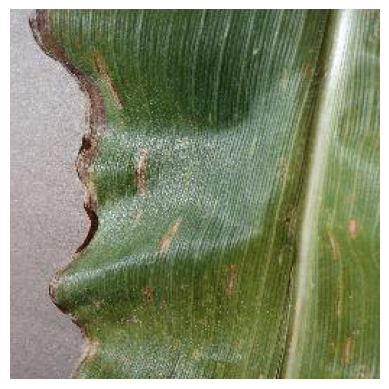

In [67]:
img_path = "../Combined_train_test/train/Corn___Cercospora_leaf_spot Gray_leaf_spot/image (6).JPG"
img = Image.open(img_path)

plt.imshow(img)
plt.grid(None) 
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

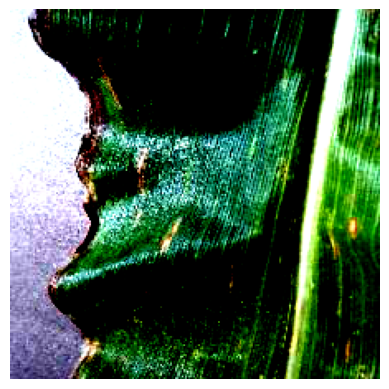

In [68]:
transformation = preprocess()
transformed_img = transformation(img)

plt.imshow(transformed_img.permute(1,2,0))
plt.grid(None) 
plt.axis('off')

In [70]:
img_tr = preprocess()(img)
 
# calculate mean and std
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])
 
# print mean and std
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([-0.0873,  0.2033, -0.1355])
Std of the image: tensor([0.6982, 0.6229, 0.8408])


In [ ]:
def preprocess2():
    transform = transforms.Compose([
                transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
                transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
                # transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                #                      std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])
    return transform